In [1]:
import numpy as np
import scipy.stats as st
import pandas as pd
from math import ceil

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='whitegrid')
import scikit_posthocs as sp
import statsmodels.stats.api as sms

from statsmodels.stats.proportion import proportions_ztest, proportion_confint

%matplotlib inline

# plt.style.use('seaborn-whitegrid')
font = {'family': 'Helvetica',
        'weight': 'bold',
        'size': 16}

# 1-й пример проведения А/В теста

Давайте представим, сто вы работаете в команде разработчиков **онлайн-бизнеса электронной комерции**. UX-дизайнер очень усердно работал над новой версией страницы продукта в надежд, что это приведет к более высокому коэффициенту конверсии. Менеджер по продукту сказал вам, что **текущий коэффициент конверсии** составляет **13%** в среднем в течение года, и что команда была бы рада **увеличению на 2%**, что означает, что новый дизайн будет считаться успешным, если он поднимет коэффициент конверсии до 15%.

Прежде чем внедрять изменения, команде было бы удобнее протестировать его на небольшом количеств пользователей, чтобы увидеть, как оно работает, поэтому вы предлагаете провести **А/В-тест** на подмножестве пользователей вашей пользовательской базы.

## Планирование эксперимента

Прежде всего, необходимо сформулировать нулевую гипотезу, чтобы не ошибиться при интерпретации результатов.

Поскольку мы не знаем, будет ли новый дизайн работать лучше или хуже (или бедут таким же?), как наш теукщий дизайн, мы выберем двусторонний тест:
- Н0: р = ро
- На: р != ро

где р и ро - коэффициенты конверсии нового и старого дизайна соотсетственно. Мы также установим уровень довтоверности 0,95% (альфа = 0,05)

Для нашего теста понадобятся две группы:
- Контрольная (control) - им будет показан старый дизайн.
- экспериментальная (treatment) - им будет показан новый дизайн.

Закодируем для каждого сианса пользоватля двоичной переменной:
- 0 - конверсии не было,
- 1 - конверсия была.

### Выбор размера выборки

Необходимый нам размер выборки оценим с помощью так называемого анализа мощности, и это зависит от нескольких факторов:
- **Мощность теста**(1 - бета) - это вероятность обнаружить статистически значимую разницу между группами, когда эта разница действительно присутствует. Как правило, это значения равно 0,8.
- **Альфа-значение** - критическое значение выставляем 0,05.
- **Величина эффекта** - ожидаемая разница между коэффициентами конверсии. Поскольку нашу команду устроила бы разница в 2%, мы можем использовать 13% и 15% для расчета ожидаемой величины эффекта.

In [2]:
p1 = 0.13
p2 = 0.15

In [3]:
# рассчитываем размер эффекта:
effect_size = sms.proportion_effectsize(p1, p2)
effect_size

-0.0576728617308947

In [4]:
# считаем необходимое количество замеров:
required_n = sms.NormalIndPower().solve_power(
    effect_size,
    power=0.8,
    alpha=0.05,
    ratio=1
)

required_n = ceil(required_n)
required_n

4720

Нам пртребуется на менее 4720 наблюдений для каждой группы

### Сбор и прдготовка данных

In [5]:
df = pd.read_csv('Practice_AB/ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [7]:
# Смотрим: есть ли пересечения
pd.crosstab(df['group'], df['landing_page'])

landing_page,new_page,old_page
group,,
control,1928,145274
treatment,145311,1965


Есть пересечения:
- 1928 пользователей из контрольной группы видели новую версию страницы
- 1965 пользователей из экспериментальной группы видели старую версию страницы

Удалим эти значения:

In [8]:
session_counts = df['user_id'].value_counts(ascending=False)
multi_users = session_counts[session_counts > 1].count()

print(f'В нашем наборе данных присутствует {multi_users} повторений пользователей по ID')

В нашем наборе данных присутствует 3894 повторений пользователей по ID


In [9]:
users_to_drop = session_counts[session_counts > 1].index

df = df[~df['user_id'].isin(users_to_drop)]
print(f'После очищения имеем {df.shape[0]} записей')

После очищения имеем 286690 записей


In [10]:
# Смотрим: есть ли пересечения
pd.crosstab(df['group'], df['landing_page'])

landing_page,new_page,old_page
group,,
control,0,143293
treatment,143397,0


Ура! Пересечений нет!

### Выборка

In [11]:
# расчетный объем выборки для каждой подгруппы:
required_n

4720

In [12]:
# Случайным образом выбираем по 4720 записей из каждой подгруппы и объединяем их в датасет
controle_sample = df[df['group'] == 'control'].sample(n=required_n, random_state=22)
treatment_sample = df[df['group'] == 'treatment'].sample(n=required_n, random_state=22)

ab_test = pd.concat([controle_sample, treatment_sample], axis=0)
ab_test.reset_index(drop=True, inplace=True)

In [13]:
ab_test

,user_id,timestamp,group,landing_page,converted
0,763854,2017-01-21 03:43:17.188315,control,old_page,0
1,690555,2017-01-18 06:38:13.079449,control,old_page,0
2,861520,2017-01-06 21:13:40.044766,control,old_page,0
3,630778,2017-01-05 16:42:36.995204,control,old_page,0
4,656634,2017-01-04 15:31:21.676130,control,old_page,0
...,...,...,...,...,...
9435,908512,2017-01-14 22:02:29.922674,treatment,new_page,0
9436,873211,2017-01-05 00:57:16.167151,treatment,new_page,0
9437,631276,2017-01-20 18:56:58.167809,treatment,new_page,0
9438,662301,2017-01-03 08:10:57.768806,treatment,new_page,0


In [14]:
ab_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9440 entries, 0 to 9439
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   user_id       9440 non-null   int64 
 1   timestamp     9440 non-null   object
 2   group         9440 non-null   object
 3   landing_page  9440 non-null   object
 4   converted     9440 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 368.9+ KB


In [15]:
ab_test['group'].value_counts()

control      4720
treatment    4720
Name: group, dtype: int64

### Визуализация

In [16]:
conversion_rates = ab_test.groupby('group')['converted']

std_p = lambda x: np.std(x, ddof=0)
se_p = lambda x: st.sem(x, ddof=0)

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['конверсия', 'сред. кв. отклонение', 'ошибка среднего']

conversion_rates.style.format('{:.3f}')

,конверсия,сред. кв. отклонение,ошибка среднего
group,,,
control,0.123,0.329,0.005
treatment,0.126,0.331,0.005


Судя по приведенной выше статистике, похоже, что наши два проекта работали очень похоже, а наш новый дизайн работал немного лучше - **коэффициент конверсии 12,3% против 12,6%**

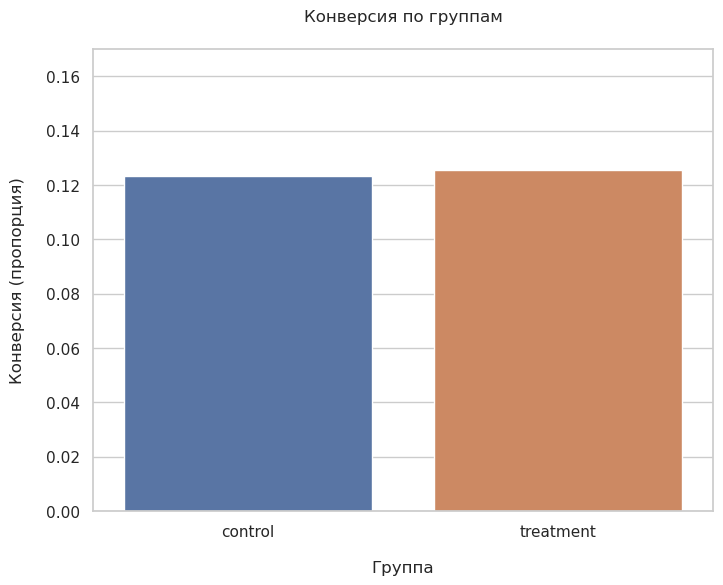

In [17]:
plt.figure(figsize=(8, 6))

sns.barplot(x=ab_test['group'], y=ab_test['converted'], errorbar=('ci', False))

plt.ylim(0, 0.17)
plt.title('Конверсия по группам', pad=20)
plt.xlabel('Группа', labelpad=15)
plt.ylabel('Конверсия (пропорция)', labelpad=15);

### Проверка гипотезы

Так как у нас очень большая выборка, мы можем использовать нормальное приближение для расчета нашего значения *р* (т.е. z-тест).

In [18]:
control_results = ab_test[ab_test['group'] == 'control']['converted']
treatment_results = ab_test[ab_test['group'] == 'treatment']['converted']

In [19]:
n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

In [20]:
# Проводим z-тест
z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

In [21]:
print(f'z-статистика = {z_stat:.2f}')
print(f'p-value = {pval:.3f}')
print(f'ДИ 95% для контрольной группы = [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ДИ 95% для тестовой группы = [{lower_treat:.3f}, {upper_treat:.3f}]')

z-статистика = -0.34
p-value = 0.732
ДИ 95% для контрольной группы = [0.114, 0.133]
ДИ 95% для тестовой группы = [0.116, 0.135]


### Выводы

Поскольку наше значение *p* = 0.755 намного превышает значение альфа = 0.05, мы не можем отвергнуть нулевую гипотезу. А это означает, что наш новый дизайн не имел существенных отличий (не говоря уже о лучшем) от нашего старого.

Кроме того доверительный интевал для тестовой группы включает наше базовое значение коэффициента конверсии 13% и не включает наше целевое значение в 15% (2% роста, к которому мы стремились).

# 2-й пример проведения А/В теста

Данные получены от 90189 игроков, которые установили игру во время проведения АВ-теста.

Переменные:
- **userid** - уникальный номер, идентифицирующий каждого играка.
- **version** - был ли игрок помещен в контрольную группу (gate_30) или в тестовую группу (gate_40).
- **sum_gamerounds** - количество игровых раундов, сыгранных игроком в течение первой недели после установки.
- **retention_1** - проигрыватель вернулся и поиграл через 1 день после установки?
- **retention_7** - проигрыватель вернулся и играл через 7 дней после установки?

Когда игрок устанавливал игру, ему случайным образом назначали gate_30 или gate_40.

**Задание: провести анализ данных и сделать выводы о лучшем месте для установки ворот.**

In [22]:
data = pd.read_csv('ab_homework/cookie_cats.csv', on_bad_lines='skip')
data.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [23]:
data.groupby('version').version.count()

version
gate_30    44700
gate_40    45489
Name: version, dtype: int64

In [24]:
# посмотрим на количество игравших через 1 и 7 дней по группам
data.groupby('version').sum()

,userid,sum_gamerounds,retention_1,retention_7
version,,,,
gate_30,222944098441,2344795,20034,8502
gate_40,227857702576,2333530,20119,8279


In [25]:
# посмотрим на средний раунд:
data.groupby('version').mean()

,userid,sum_gamerounds,retention_1,retention_7
version,,,,
gate_30,4.987564e+06,52.456264,0.448188,0.190201
gate_40,5.009073e+06,51.298776,0.442283,0.182000


Среднее значение раундов в группе gate_30 несколько выше. Попробуем это доказать старистически.

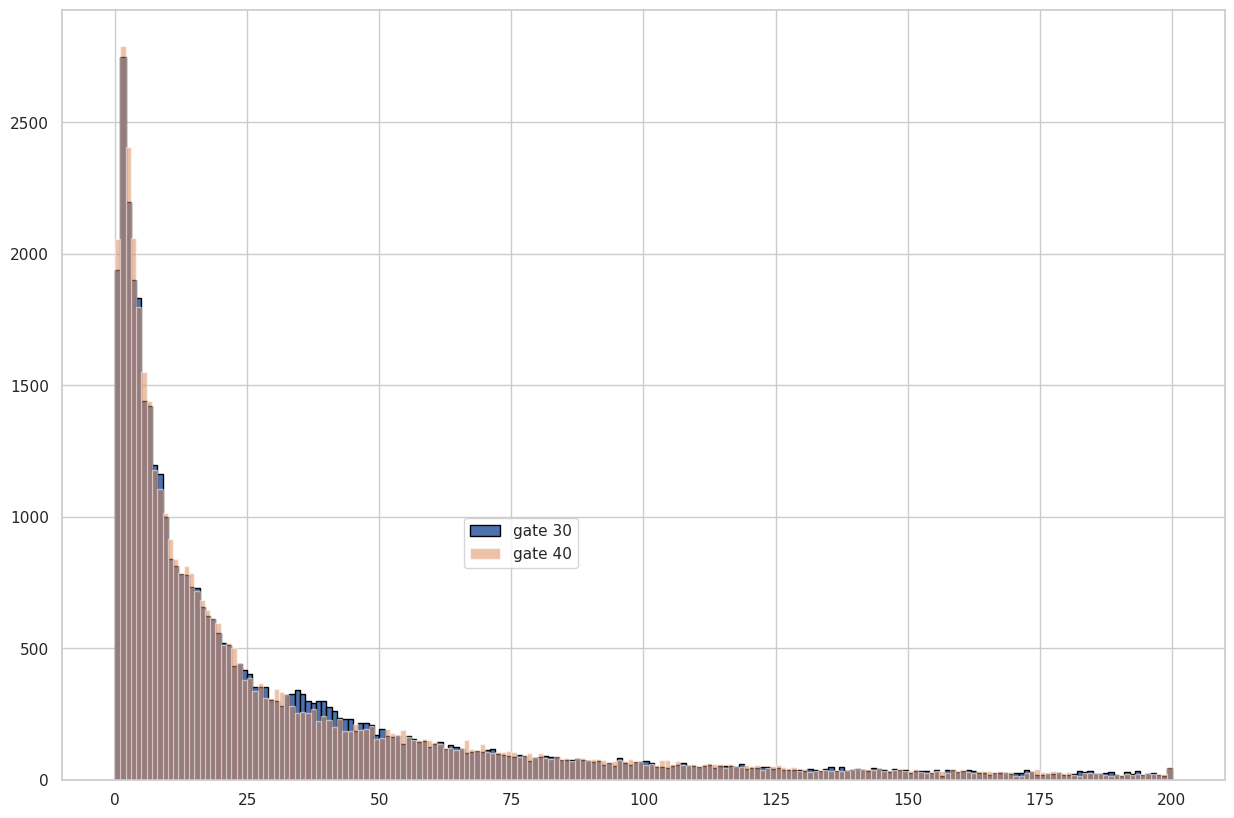

In [26]:
v_30 = data.loc[data.version == 'gate_30']
v_40 = data.loc[data.version == 'gate_40']

v_30 = v_30.drop(v_30.loc[v_30.sum_gamerounds > 200].index)
v_40 = v_40.drop(v_40.loc[v_40.sum_gamerounds > 200].index)

# строим гистограммы:
bins = 200
plt.figure(figsize=(15, 10))
plt.hist(v_30['sum_gamerounds'], bins=bins, alpha=1, edgecolor='black', label='gate 30')
plt.hist(v_40['sum_gamerounds'], bins=bins, alpha=0.5, label='gate 40')
plt.legend(loc='upper right', bbox_to_anchor=(0.45, 0.35))
plt.show()

/home/andrew/.local/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


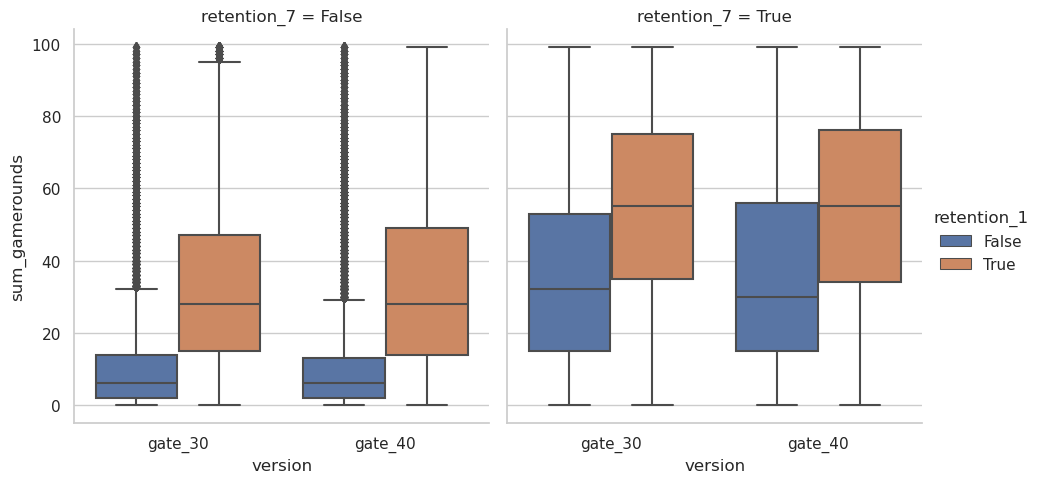

In [27]:
df = data.loc[data['sum_gamerounds'] < 100].copy();

sns.catplot(x='version', y='sum_gamerounds', hue='retention_1', col='retention_7', data=df, kind='box', height=5, aspect=0.95);

**Какие тесты мы знаем?**

Так как распределение данных не нормальное, попробуем использовать тест Манна-Уитней.

In [28]:
stat, p = st.mannwhitneyu(data[data['version'] == 'gate_30']['sum_gamerounds'],
                          data[data['version'] == 'gate_40']['sum_gamerounds'])
print(f'Статистика = {stat:.3f}, p-value = {p:.3f}')
if p > 0.05:
    print("Не отклоняем нулевую гипотезу, распределения, вероятно, одинаковые")
else:
    print("Отклоняем нулевую гипотезу, распределения, вероятно, различаются")

Статистика = 1024331250.500, p-value = 0.050
Не отклоняем нулевую гипотезу, распределения, вероятно, одинаковые


### Применяем Bootstrap для того, чтобы более наглядно убедиться в нуличии различий

In [29]:
plt.figure(figsize=(15, 10))

boot_1d = []
for i in range(1000):
    boot_mean = data.sample(frac=1, replace=True).groupby('version')['retention_7'].mean()
    boot_1d.append(boot_mean)

boot_1d = pd.DataFrame(boot_1d)
boot_1d.head()

version,gate_30,gate_40
retention_7,0.190550,0.182022
retention_7,0.189605,0.184568
retention_7,0.191948,0.183733
retention_7,0.191347,0.180457
retention_7,0.193686,0.180465


<Figure size 1500x1000 with 0 Axes>

<Axes: ylabel='Density'>

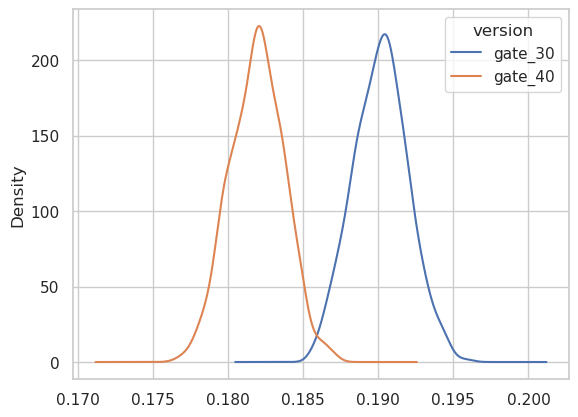

In [30]:
boot_1d.plot(kind='density')

Визуально распределение близко к нормальному. Следовательно, мы можем использовать тест Стьюдента.

Но, прежде чем использовать t-тест, необходимо проверить равенство дисперсийю Сделаем это с помощью F-теста. Используем собственную функцию.

### Проверяем равенство дисперсий

In [31]:
def f_test(group1, group2):
    f = np.var(group1, ddof=1)/np.var(group2, ddof=1)
    nun = group1.size - 1
    dun = group2.size - 1
    p_value = 1 - st.f.cdf(f, nun, dun)
    return f, p_value

In [32]:
stat, p = f_test(boot_1d['gate_30'], boot_1d['gate_40'])
print(f'Статистика = {stat:.3f}, p-value = {p:.5f}')
if p > 0.05:
    print('Не отклоняем нулевую гипотезу, дисперсии, вероятно, одинаковые')
else:
    print('Отклоняем нулевую гипотезу, дисперсии, вероятно, различаются')

Статистика = 1.019, p-value = 0.38452
Не отклоняем нулевую гипотезу, дисперсии, вероятно, одинаковые


### Применяем t-критерий Стьюдента

In [33]:
stat, p = st.ttest_ind(boot_1d['gate_30'], boot_1d['gate_40'])
print(f'Статистика = {stat:.3f}, p-value = {p:.10f}')
if p > 0.05:
    print('Не отклоняем нулевую гипотезу, средние, вероятно, одинаковые')
else:
    print('Отклоняем нулевую гипотезу, средние, вероятно, различаются')

Статистика = 101.632, p-value = 0.0000000000
Отклоняем нулевую гипотезу, средние, вероятно, различаются


**Выводы.** Существует статистически значимая разница мажду тем, гду поставить ворота.